
3. **Colorizing images [30 points total, 3 parts].** 

  In this problem we will learn to work with images by taking the digitized [Prokudin-Gorskii glass plate images](https://www.loc.gov/exhibits/empire/gorskii.html) and automatically producing a color image with as few visual artifacts as possible. In order to do this, you will need to extract the three color channel images, place them on top of each other, and align them so that they form a single RGB color image. 

  **a)** &ensp; **Read images [5 pts].** We'll start simple. Our first task is to read the file [00351v.jpg](https://drive.google.com/file/d/11fwxjlZkDOApoVZx0Pr4am1ClA6qdNaY/view?usp=sharing), extract the three color channel images and display each of them. Note that the filter order from top to bottom is BGR.

In [1]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

def crop_bgr_from_img(img_path: str)->[np.array,np.array,np.array]:
    """
     Read the file as a numpy array and crop the three color channel images. 
     Note that the filter order from top to bottom is BGR.
     
     :param img_path: the path to the image file, which is a string.
     
     :return: blue, green and red color channel images. Each of them is a 341x396 numpy array.
    """
     
    img=np.array(Image.open(img_path),dtype=np.uint16)
    
    # Renormlize the pixel value to be in range [0,255].
    img=255*(img*1.0-np.min(img))/(np.max(img)-np.min(img))
    img=np.uint8(img)
    
    h,w=img.shape
     
    # Extract the three color channel images from top to bottom.   
    seg_h=h//3   
    
    # ADD YOUR CODE HERE (5 pts)
    blue= img[:seg_h,:]
    green= img[seg_h:2*seg_h,:]
    red= img[2*seg_h:3*seg_h,:]

    # Make sure the three color channel images have the same shape
    assert blue.shape==green.shape==red.shape

    #print(blue.shape)

    return blue,green,red



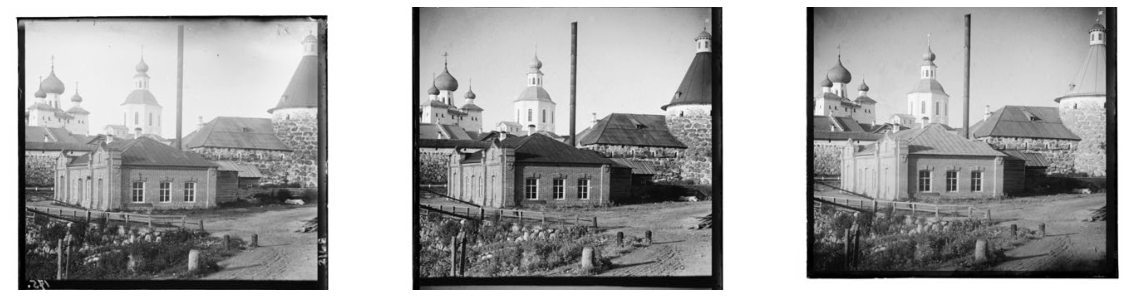

In [2]:
blue,green,red=crop_bgr_from_img('00351v.jpg')

# Display three color channel images
plt.figure(figsize=(20,20))
for i,img_arr in enumerate([blue,green,red]):
    img=Image.fromarray(img_arr)
    plt.subplot(1,3,i+1)
    plt.axis('off')
    plt.imshow(img,cmap='gray')

b)** &ensp; **Basic alignment [10 pts].** Now that we've divided the image into three channels, the next thing to do is to align two of the channels to the third. The easiest way to align the parts is to exhaustively search over a window of possible displacements (say [-15,15] pixels independently for the x and y axis), score each one using some image matching metric, and take the displacement with the best score. We can use normalized cross-correlation (NCC) as the image matching metric, which is simply the dot product between the two images normalized to have zero mean and unit norm. 

In [3]:
def ncc(img_a: np.array,img_b: np.array)->float:
    """
    return normalized dot product of the arrays img1, img2
    """
    v1 = np.ravel(img_a)
    v2 = np.ravel(img_b)

    norm1 = np.linalg.norm(v1)
    norm2 = np.linalg.norm(v2)
  
    ncc=np.dot(v1/norm1,v2/norm2)

    # ADD YOUR CODE HERE (5 pts)

    return ncc

Then, we align two color channel images by exhaustively searching over a window of possible displacements, score each one using NCC, and take the displacement with the best score. (Hint: you can use np.roll function to shift the entire image by the specified displacement.

In [4]:
def align_imga_to_imgb(img_a:np.array,img_b:np.array, wd_size:int=15)->(np.array,(int,int)):
    """
     Align two color channel images. Return the aligned image_a and its displacement.
     
     :param img_a: the image to be shifted, which is a 341x396 numpy array.
     :param img_b: the image that is fixed, which is a 341x396 numpy array.
     
     :return: a tuple of (aligned_a, displacement_of_a). ''aligned_a'' is the aligned image_a,
     which is a 341x396 numpy array.''displacement_of_a'' is the displacement vector of img_a, which is 
     a tuple of (row displacement, column displacement).
    """  
    
    # Initialize the image matching score.
    score=0

    # Initialize the aligned image A.
    aligned_a=None

    #Initialize the displacement vector.
    displacement=(0,0)

    # Shift image A whithin range [-wd_size, wd_size], score each shifted image
    # and take the one with the best score.
    for i in range(-wd_size,wd_size):
        for j in range(-wd_size,wd_size):
            # Shift img_a's rows by i pixels, columns by j pixels           
            shifted_a= np.roll(img_a, (i,j), axis=(0,1))# ADD YOUR CODE HERE (5 pts)
            
            new_score=ncc(shifted_a,img_b)
            
            if new_score>score:
                score=new_score
                aligned_a=shifted_a
                displacement=[i,j]  
    return  aligned_a,displacement

Finally, we can display the colorized output and the (x,y) displacement vector that were used to align the channels.

Displacement of aligning the red channel to the green channel: [9, 0]
Displacement of aligning the green channel to the green channel: [0, 0]
Displacement of aligning the blue channel to the green channel: [-4, 0]


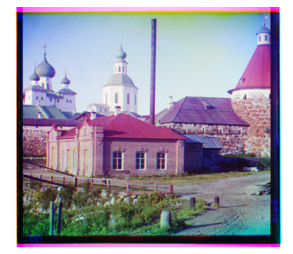

In [5]:
def colorize_image(b:np.array,g:np.array,r:np.array)->(np.array,list):
    """
     Align the three color channel images. Return the colored image 
     and a list of the displacement vector for each channel.
     
     :param b: the blue channel image, which is a 341x396 numpy array.
     :param g: the greeb channel image, which is a 341x396 numpy array.
     :param r: the red channel image, which is a 341x396 numpy array.
     
     :return: a tuple of (colored_image, displacements). ''colored_image'' is a 341x396x3 numpy array.
     ''displacements'' is a list of the displacement vector for each channel. 
    """  
    
    # Align the red and blue channels to the green channel.
    aligned_r,dis_r = align_imga_to_imgb(r,g)    
    aligned_b,dis_b = align_imga_to_imgb(b,g)

    aligned_g,dis_g=g,[0,0]

    # Combine the aligned channels to a color image.
    colored_img=np.stack([aligned_r,aligned_g,aligned_b],axis=2)
    
    return colored_img,[dis_r,dis_g,dis_b]

colored_img,displacements=colorize_image(blue,green,red)
print('Displacement of aligning the red channel to the green channel:',displacements[0])
print('Displacement of aligning the green channel to the green channel:',displacements[1])
print('Displacement of aligning the blue channel to the green channel:',displacements[2])
plt.figure(figsize=(5,5))
plt.axis('off')
plt.imshow(colored_img)

**c)** &ensp; **Multiscale alignment [15 pts].** Now let's try colorizing the high-resolution image [01047u.tif](https://drive.google.com/file/d/1HbmTOLAw_f64wurxJyorOraKGX6EIree/view?usp=sharing). This image is of size 9656 x 3741. Therefore, exhaustive search over all possible displacements will become prohibitively expensive. To deal with this case, we can implement a faster search procedure using an image pyramid. An image pyramid represents the image at multiple scales (usually scaled by a factor of 2) and the processing is done sequentially starting from the coarsest scale (smallest image) and going down the pyramid, updating your estimate as you go. It is very easy to implement by adding recursive calls to your original single-scale implementation. The running time of your implementation should be less than 1 minute.

In [7]:
def colorize_image_recursively(b:np.array,g:np.array,r:np.array)->(np.array,list):
    """
     Align the high-resolution three color channel images. Return the colored image 
     and a list of the displacement vector for each channel.
     
     :param b: the high-resolution blue channel image, which is a 3218x3741 numpy array.
     :param g: the high-resolution greeb channel image, which is a 3218x3741 numpy array.
     :param r: the high-resolution red channel image, which is a 3218x3741 numpy array.
     
     :return: a tuple of (colored_image, displacements). ''colored_image'' is a 3218x3741x3 numpy array.
     ''displacements'' is a list of the displacement vector for each channel. 
    """  
    colored_img=None
    displacements=[]
    
    # ADD YOUR CODE HERE (15 pts)
    if(b.shape[0]<400):
        aligned_r,dis_r = align_imga_to_imgb(r,g)    
        aligned_b,dis_b = align_imga_to_imgb(b,g)
        aligned_g,dis_g=g,(0,0)
        colored_img=np.stack([aligned_r,aligned_g,aligned_b],axis=2)
        #colored_img,[dis_r,dis_g,dis_b]=colorize_image(b,g,r)
        return colored_img,[dis_r,dis_g,dis_b]   
    else:
        b_new=b[::2,::2]
        g_new=g[::2,::2]
        r_new=r[::2,::2]
        colored_img,displacements=colorize_image_recursively(b_new,g_new,r_new)
        l_r=list(displacements[0])
        l_g=list(displacements[1])
        l_b=list(displacements[2])
        l_r[0]*=2
        l_r[1]*=2
        l_g[0]*=2
        l_g[1]*=2
        l_b[0]*=2
        l_b[1]*=2
        r,dis_r = align_imga_to_imgb(np.roll(r, l_r, (0, 1)),g,5)
        b,dis_b = align_imga_to_imgb(np.roll(b, l_b, (0, 1)),g,5)
        g,dis_g=g,(0,0)
        #colored_img,[dis_r,dis_g,dis_b]=colorize_image(np.roll(b, l_b, (0, 1)),g,np.roll(r, l_r, (0, 1)))
        l_r[0]+=list(dis_r)[0]
        l_r[1]+=list(dis_r)[1]
        l_g[0]+=list(dis_g)[0]
        l_g[1]+=list(dis_g)[1]
        l_b[0]+=list(dis_b)[0]
        l_b[1]+=list(dis_b)[1]
        colored_img=np.stack([r,g,b],axis=2)
    
    return colored_img,[l_r,l_g,l_b]
    

Displacement of aligning the red channel to the green channel: [48, 12]
Displacement of aligning the green channel to the green channel: [0, 0]
Displacement of aligning the blue channel to the green channel: [-26, -2]


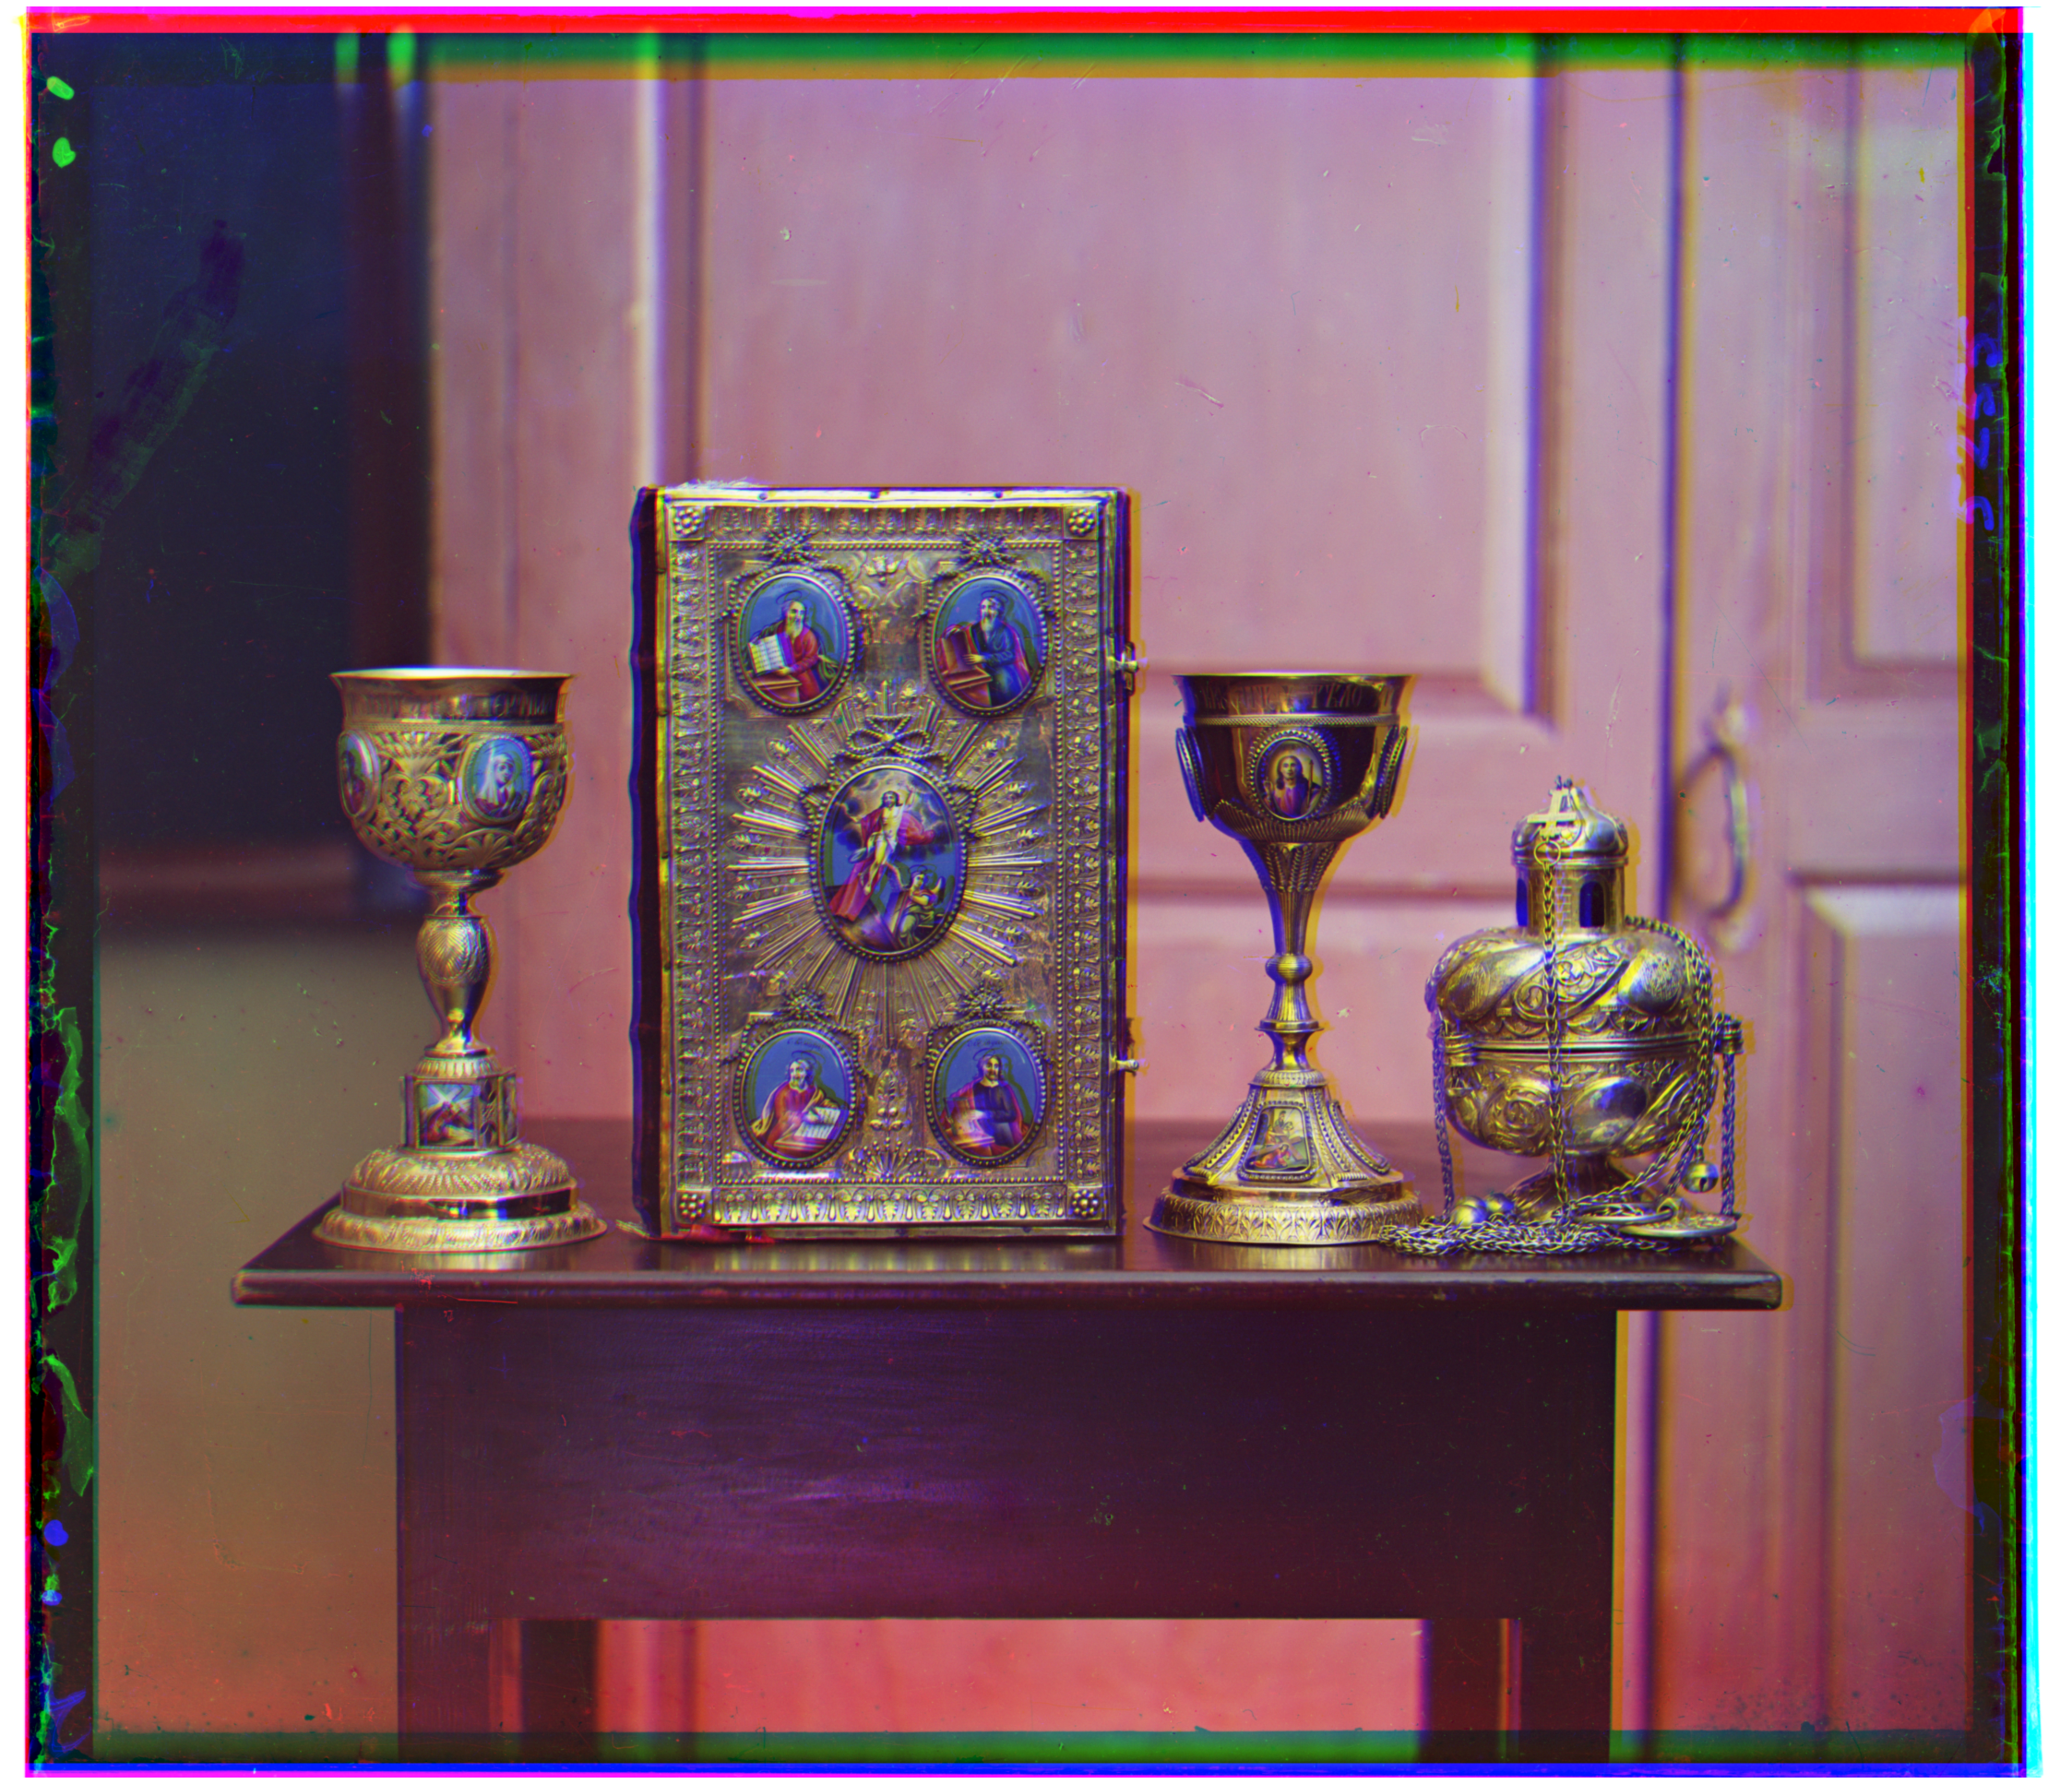

In [8]:
blue,green,red=crop_bgr_from_img('01047u.tif')
hrs_colored_img,hrs_displacements=colorize_image_recursively(blue,green,red)
print('Displacement of aligning the red channel to the green channel:',hrs_displacements[0])
print('Displacement of aligning the green channel to the green channel:',hrs_displacements[1])
print('Displacement of aligning the blue channel to the green channel:',hrs_displacements[2])
plt.figure(figsize=(40,40))
plt.axis('off')
plt.imshow(hrs_colored_img)

**d)** &ensp; **Improve the alignment [5 bonus pts].** The borders of the photograph will have strange colors since the three channels won't exactly align. See if you can devise an automatic way of cropping the border to get rid of the bad stuff. One possible idea is that the information in the good parts of the image generally agrees across the color channels, whereas at borders it does not.

In [9]:
def crop_border(img:np.array)->np.array:
    """
     Crop the border to get rid of strange colors in the image.
     
     :param img: the colorized image, which is a 341x396x3 numpy array.
     :return: the improved image, which is a HxWx3 numpy array.
    
    """
    h, w, c = img.shape
    t, d, l, r = np.zeros(c), np.zeros(c), np.zeros(c), np.zeros(c)#top,down,left and right crop list

    for i in range(3):
        t[i] = np.argmax(np.diff(np.std(img[:, :, i],axis=1)[:30])) + 1
        d[i] = h - 30 + np.argmax(np.diff(np.std(img[:, :, i],axis=1)[-30:])) + 1
        l[i] = np.argmax(np.diff(np.std(img[:, :, i],axis=0)[:30])) + 1
        r[i] = w - 30 + np.argmin(np.diff(np.std(img[:, :, i],axis=0)[-30:])) + 1
    
    # Crop the image
    new_img = img[int(max(t)):int(min(d)), int(max(l)):int(min(r))]
    return new_img
        
    


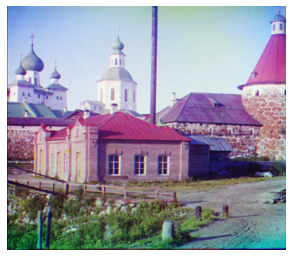

In [10]:
new_img=crop_border(colored_img)
plt.figure(figsize=(5,5))
plt.axis('off')
plt.imshow(new_img)